# Modèles à variable dépendante limitée

Cette application reprend la proposition de Stock et Watson (le manuel) qui utilisent les données de l'article de Alicia H Munnell, Geoffrey MB Tootell, Lynn E Browne, and James McEneaney : "Mortgage lending in
boston: Interpreting hmda data." *The American Economic Review*, pages 25-53, 1996.

Dans cet article, les chercheurs de la Federal Reserve Bank de Boston souhaitent savoir les noirs américains sont discriminés dans l'accès au crédit immobilier. Ils collectent des données sur les demandes de prêts immobiliers en 1990 dans Boston et sa banlieue. Ils obtiennent 2380 observations de demandeurs blanc et noir-américain. 

Les données sont décrites dans le codebook simplifié : **TD6_codebook.png** : 

![title](TD6_codebook.png)

## Intuition
On ouvre la base de données : **TD6_hdma_v12.dta**. 

In [1]:
library(foreign)
hdma<-read.dta("TD6_hdma_v12.dta")
#on a la variable 'black' numérique qui nous donne l'ethnie
#à partir de cette variable on crée une variable facteur 'hdma$blackcategory' pour définir dans R que cette variable n'est une variable continue mais une variable catégorielle
hdma$blackcategory<-factor(hdma$black, levels=c(0,1), labels=c("White","Black")) #on transforme Black en facteur pour plus de l
#la plupart du temps on utilisera la variable catégorielle 'hdma$blackcategory'
#mais pour calculer les effets marginaux à la moyenne à la main on aura besoin de la porportion de Noirs américains'
#et on utilisera exceptionnellement la numérique: 'hdma$black'
dim(hdma)
head(hdma)

[1] 2380   15

deny,pi_rat,black,hse_inc,loan_val,ccred,mcred,pubrec,denpmi,selfemp,single,hischl,probunmp,condo,blackcategory
0,0.221,0,0.221,0.8000000,5,2,0,0,0,0,1,3.9,0,White
0,0.265,0,0.265,0.9218750,2,2,0,0,0,1,1,3.2,0,White
0,0.372,0,0.248,0.9203980,1,2,0,0,0,0,1,3.2,0,White
0,0.320,0,0.250,0.8604651,1,2,0,0,0,0,1,4.3,0,White
0,0.360,0,0.350,0.6000000,1,1,0,0,0,0,1,3.2,0,White
0,0.240,0,0.170,0.5105263,1,1,0,0,0,0,1,3.9,0,White


Les noirs-américains (*black*) ont-ils effectivement une probabilité plus importante de voir leur demande de prêt rejetée (*deny*) ? 

*Indice : proposez un tableau de proportions, un test d'égalité de moyennes ou une régression linéaire simple.*

In [2]:
#test d'égalité de moyennes
t.test(deny~blackcategory, data=hdma)


	Welch Two Sample t-test

data:  deny by blackcategory
t = -7.5232, df = 385.65, p-value = 3.8e-13
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.2403921 -0.1407763
sample estimates:
mean in group White mean in group Black 
         0.09260167          0.28318584 


In [3]:
#régression linéaire simple
lpm1 <- lm(deny~blackcategory,data=hdma)
summary(lpm1)


Call:
lm(formula = deny ~ blackcategory, data = hdma)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.2832 -0.0926 -0.0926 -0.0926  0.9074 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        0.092602   0.007037   13.16   <2e-16 ***
blackcategoryBlack 0.190584   0.018644   10.22   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3179 on 2378 degrees of freedom
Multiple R-squared:  0.04209,	Adjusted R-squared:  0.04169 
F-statistic: 104.5 on 1 and 2378 DF,  p-value: < 2.2e-16


<font color=green> 
Réponse : Les noirs-américains ont une probabilité plus grande de voir leur demande de prêt rejetée. Un simple tableau croisé permet de le dire (en ligne 0/1 correspond à l’ethnie, en colonne on le taux de rejet). Alors que 9,1\% des dossiers de demande des blanc-américains sont rejetés, c’est le cas de 28,3\% des dossiers des noir-américains. 
    
On retrouve exactement la même chose si on fait un test de moyenne, ou une régression simple de la variable binaire de rejet sur l’origine ethnique : la constante donne la proportion des rejets pour la population blanche (9,1) et le coefficient donne l’effet additionnel du fait d’être noir : +19,2 => ce qui donne bien 28.3\%. Le test d'égalité de moyenne ou la régression permettent de dire que la différence est significativement différente de 0.
</font>

Grâce à des tests d'égalité de moyennes, déterminez si les blancs-américains sont de bons contrefactuels pour les noirs-américains. Peut-on donc interpréter la différence de traitement de la question précédente comme de la discrimination ?

In [4]:
t.test(hdma$selfemp ~ hdma$blackcategory)
t.test(hdma$single ~ hdma$blackcategory)
t.test(hdma$hischl ~ hdma$blackcategory)
t.test(hdma$probunmp ~ hdma$blackcategory)


	Welch Two Sample t-test

data:  hdma$selfemp by hdma$blackcategory
t = 3.1129, df = 532.66, p-value = 0.001952
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.01834425 0.08110090
sample estimates:
mean in group White mean in group Black 
         0.12346889          0.07374631 



	Welch Two Sample t-test

data:  hdma$single by hdma$blackcategory
t = -4.9074, df = 449.22, p-value = 1.293e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.20078194 -0.08595356
sample estimates:
mean in group White mean in group Black 
          0.3728564           0.5162242 



	Welch Two Sample t-test

data:  hdma$hischl by hdma$blackcategory
t = 1.8775, df = 387.67, p-value = 0.0612
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.0008840346  0.0383432592
sample estimates:
mean in group White mean in group Black 
          0.9862812           0.9675516 



	Welch Two Sample t-test

data:  hdma$probunmp by hdma$blackcategory
t = 4.0982, df = 583.33, p-value = 4.753e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.2000072 0.5681301
sample estimates:
mean in group White mean in group Black 
           3.829201            3.445133 


<font color=green> L’ensemble de ces tests sont des tests d’égalité de moyenne entre blancs et noirs-américains pour différentes caractéristiques **prédéterminées**. On voit que ces deux populations sont très différentes pour l’ensemble des caractéristiques considérées. Problème : ces caractéristiques sont à la fois liées à l’ethnie et à la probabilité que le prêt soit rejeté. Les deux groupes ne sont pas de bons contrefactuels l’un pour l’autre.  L’effet de l’ethnie est biaisé. Les différences de 1 ne sont pas de la discrimination mais correspondent en partie à ces différences. </font>

## 1. Modèle de probabilité linéaire 
On s'intéresse à contrôler en plus pour l'effet du ratio mensualité de l'emprunt / revenu total *pi_rat* sur la probabilité de rejet. Pourquoi ? Que s'attend-on à trouver?

<font color=green> 
Pourquoi : On voit que cette variable diffère entre blancs et noirs et il se trouve que cette variable est également le premier critère de décision pour accorder un prêt. Clairement son absence dans la régression crée un biais de variable omise (surestimation de l’effet d’être noir car en parallèle les noirs ont également un taux d’endettement plus élevé ce qui explique certainement en partie le taux de rejet plus important).<br><br>
On s’attend à trouver que la relation entre rejet et endettement est positive. On s’attend à ce que le coefficient associé à la variable ethnique baisse une fois que l’on contrôle pour l’endettement.<br><br>
</font>

Rappeler ce qu'est un modèle de probabilité linéaire.

<font color=green> 
Un modèle de probabilité linéaire n’est rien d’autre qu’un modèle de régression linéaire dans lequel la variable dépendant est binaire. Le modèle est un modèle de probabilité car les coefficients s’interprètent comme l’effet d’une variation des explicatives d’une unité sur la probabilité que Y=1 (ici que le dossier soit rejeté).
</font>

Estimer et interpréter.

In [5]:
summary(hdma$pi_rat)
lpm2 <- lm(deny~blackcategory+pi_rat,data=hdma)
summary(lpm2)
#coeftest(lpm2, vcov = vcovHC(lpm2, type="HC1")) 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.2800  0.3300  0.3308  0.3700  3.0000 


Call:
lm(formula = deny ~ blackcategory + pi_rat, data = hdma)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.62526 -0.11772 -0.09293 -0.05488  1.06815 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -0.09051    0.02079  -4.354 1.39e-05 ***
blackcategoryBlack  0.17743    0.01837   9.659  < 2e-16 ***
pi_rat              0.55919    0.05987   9.340  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3123 on 2377 degrees of freedom
Multiple R-squared:  0.076,	Adjusted R-squared:  0.07523 
F-statistic: 97.76 on 2 and 2377 DF,  p-value: < 2.2e-16


<font color=green> 
    Interprétation : Quand le ratio augmente de 1point, la probabilité de rejet augmente de 0.55 points. Ceci quel que soit le ratio initial (modèle linéaire). Le coefficient de *black* ne baisse pas beaucoup.
</font>

## 2. Modèle de régression probit

On estime le modèle de régression probit de *deny* sur *black* et *pi_rat* par maximum de vraisemblance : **glm( y~x, binomial("probit"), data=... )**. Quel est le principe de l'estimation par maximum de vraisemblance ? Interpréter les résultats.

<font color=green> Maximum de vraisemblance : la fonction de vraisemblance est la fonction de distribution conditionnelle des données. L’estimateur par maximum de vraisemblance cherche les coefficients qui maximisent cette fonction de vraisemblance. Autrement dit cet estimateur cherche les paramètres qui maximisent a probabilité de tirer les données qui ont été observées.
 </font>

In [6]:
probit1 <- glm(deny ~ blackcategory + pi_rat, binomial("probit"), data = hdma)
summary(probit1)


Call:
glm(formula = deny ~ blackcategory + pi_rat, family = binomial("probit"), 
    data = hdma)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1208  -0.4762  -0.4251  -0.3550   2.8799  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -2.25879    0.13669 -16.525  < 2e-16 ***
blackcategoryBlack  0.70816    0.08335   8.496  < 2e-16 ***
pi_rat              2.74178    0.38047   7.206 5.75e-13 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1744.2  on 2379  degrees of freedom
Residual deviance: 1594.3  on 2377  degrees of freedom
AIC: 1600.3

Number of Fisher Scoring iterations: 5


<font color=green> 
Interprétation : Le fait d’être noir influence positivement la probabilité de rejet. Plus le ratio d’endettement est important, plus le rejet sera probable. On ne peut commenter les amplitudes. 
 </font>

Pourquoi l'interprétation des résultats est-elle compliquée ? 

<font color=green> L’interprétation est rendue compliquée par le fait que les coefficients ne s’interprètent pas directement. Ils ont un impact linéaire sur l’argument de la fonction de répartition de la loi normale, mais pas sur la loi normale elle-même. <br><br>
L’effet marginal n’est pas linéaire mais dépend de la valeur initiale des explicatives. <br><br>
Calcul : On utilise la fonction de densité de la loi normale. On calcule d'abord l'argument de la fonction : $z$, puis on lit l'image par la fonction de répartition grâce à la table de valeur de la fonction de répartition de la loi normale.</font>

#### 1. Effet marginal à la moyenne 
Rappeler ce qu'est l'effet marginal à la moyenne.

<font color=green> Effet marginal à la moyenne = effet marginal pour l'individu moyen.</font>

En vous aidant du code ci-dessous, calculez l'effet marginal du fait d'être noir-américain sur la probabilité de rejet. Pour cela, calculez d'abord la probabilité de rejet de l'individu moyen noir, puis de l'individu moyen blanc. Calculez ensuite la différence.

*Indice: La fonction de répartition de la loi normale s'écrit :* **pnorm()** 

In [7]:
#voir les coefficients:
coef(probit1)

(Intercept) blackcategoryBlack             pi_rat 
        -2.2587870          0.7081554          2.7417794

In [8]:
#Prob for blacks at means
z1  <- coef(probit1)[1] + coef(probit1)[2] + coef(probit1)[3]*mean(hdma$pi_rat)
Gz1 <- pnorm(z1)
#Prob for whites at means
z0  <- coef(probit1)[1] + coef(probit1)[3]*mean(hdma$pi_rat)
Gz0 <- pnorm(z0)
#Difference in probs
Gz1-Gz0

(Intercept) 
  0.1716884

<font color=green> En moyenne, différence de 17 points selon la couleur de peu de l'individu moyen.  </font>

Calculer l'effet marginal du fait d'avoir un ratio d'endettement de 10 points de pourcentage plus élevé pour l'individu moyen. Pour ce faire calculez la proba de rejet de l'individu moyen, puis de l'individu moyen avec 0.1 de ratio d'endettement supplémentaire. Calculez ensuite la différence.

In [9]:
###Calculer l'effet marginal du fait d'avoir un ratio d'endettement de 10 points de pourcentage plus ?lev? pour l'individu moyen.
#J'ai besoin de la proportion des noirs-américains: j'utilise la variable numérique 'black' plutôt que la variable catégorielle 'blackcategory'
#Prob at means
z0  <- coef(probit1)[1] + coef(probit1)[2]*mean(hdma$black) + coef(probit1)[3]*mean(hdma$pi_rat)
Gz0 <- pnorm(z0)
z1  <- coef(probit1)[1] + coef(probit1)[2]*mean(hdma$black) + coef(probit1)[3]*(mean(hdma$pi_rat)+0.1)
Gz1 <- pnorm(z1)
Gz1-Gz0

(Intercept) 
  0.0588678

<font color=green> $0.16-0.10=0.06$. En moyenne, différence de 6 points dans la proba de rejet suite à une augmentation de 0.1 du ratio d'endettement.  </font>

#### 2. Effet marginal moyen

Rappeler ce qu'est l'effet marginal moyen.





<font color=green> L’effet marginal moyen = la moyenne des effets marginaux de l’échantillon.</font>


Que mesure ce code ?

*Indice: La fonction de densité de la loi normale s'écrit :* **dnorm()**

In [10]:
#J'ai besoin de la valeur numérique 0/1 signalant les noirs-américains: j'utilise la variable numérique 'black' plutôt que la variable catégorielle 'blackcategory'
hdma$gg<-dnorm(coef(probit1)[1] + coef(probit1)[2]*hdma$black + coef(probit1)[3]*hdma$pi_rat)
scalefactor<-mean(hdma$gg)
scalefactor

[1] 0.1828813

<font color=green> C'est le facteur d'échelle tel que défini dans le cours : $\frac{\sum_{i=1}^{n}g(\hat{\beta}_0+\hat{\beta}_1 black_i+\hat{\beta}_2 pi\_rat_i)}{n}$. Il sert à calculer l'effet marginal moyen (moyenne des effets marginaux). </font>

Calculer l'effet marginal moyen du ratio d'endettement. 

In [11]:
effet_marginal_moyen <-scalefactor*coef(probit1)[3]
effet_marginal_moyen

pi_rat 
0.5014202

<font color=green> Calculer l'effet marginal moyen du fait d'avoir un ratio d'endettement de 10 points de pourcentage plus élevé. Calcul : On calcule la moyenne des effets partiels sur l’échantillon. Cela revient à multiplier le terme de la question : 0.1828 par le coefficient en question. Ici : $0.1828*2.7417=0.5014$. C'est l'effet de l'augmentation du ratio de 0 à 1 soit +100 points. Je le divise par 10 pour trouver l'effet de 10 points: 0.050 soit + 5 points de pourcentage de probabilité de rejet. L'effet marginal moyen est généralement proche de l'effet mis en évidence par le modèle linéaire. Il peut être différent de l'effet marginal à la moyenne (= pour l'individu moyen, cf question précédente).  </font>

In [12]:
#NOTE : on peut calculer l'effet marginal très simplement avec margins :
install.packages("margins")
library(margins)
AME<-margins(probit1)
summary(AME)

package 'margins' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\lmartinoty\AppData\Local\Temp\RtmpYHPp3n\downloaded_packages


factor,AME,SE,z,p,lower,upper
blackcategoryBlack,0.1695923,0.02424322,6.995453,2.644039e-12,0.1220764,0.2171081
pi_rat,0.5014205,0.06901215,7.265684,3.711557e-13,0.3661591,0.6366818


## 3. Comparaison des deux modèles de régression

Calculer la probabilité de rejet quand le demandeur est blanc avec un taux d'endettement de 0.1 selon le modèle de probabilité linéaire et le modèle probit. Commentez. 



In [13]:
#Par MPL
ypred <- coef(lpm2)[1] + coef(lpm2)[3]*0.1
#Par Probit
z <- coef(probit1)[1] + coef(probit1)[3]*0.1
p=pnorm(z)
ypred
p

(Intercept) 
-0.03459414

(Intercept) 
 0.02359399

<font color=green> Commentaire : on voit qu’en plus des effets non linéaires, la force du modèle non linéaire est de contraindre les probabilités prédites à appartenir à l’intervalle 0,1. </font>

Que réprésentent les commandes et le graphique ci-dessous ?

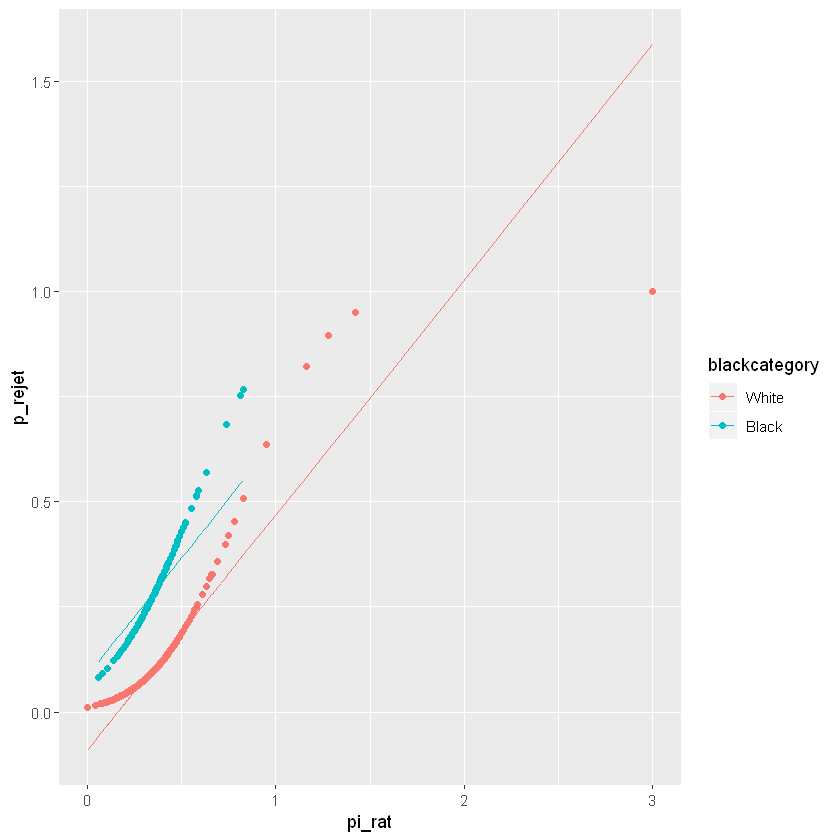

In [14]:
library(ggplot2)
hdma$p_rejet <- predict(probit1, hdma, type = "response")
hdma$y_hat <- predict(lpm2, hdma, type = "response")
ggplot(hdma, aes(x = pi_rat, y = p_rejet, colour = blackcategory))+ geom_point()+geom_line(aes(y = y_hat, colour = blackcategory))

<font color=green>  
$p\_rejet$ est la proba prédite par le modèle probit. <br>
$y\_hat$ est la proba prédite par le modèle de proba linéaire. <br>
Le graphique met en évidence les probabilités prédites de rejet pour l'ensemble des individus de l'échantillon, en fonction de $pi\_rat$, par ethnie. Pour le modèle linéaire, elles sont linéaires en $pi\_rat$. Pour le modèle non linéaire, elles sont non linéaires en $pi\_rat$ et évoluent entre 0 et 1. 
</font>

## 4. Modèle de régression probit complet

Quelles sont les autres variables que vous souhaiteriez ajouter à la régression ? 

<font color=green> Presque toutes les variables du tableau. Trois catégories : cara de l’emprunt, de l’emprunteur, et cara individuelles. Les cara qu’il est important de tenir en compte : variables en lien avec l’ethnie ET en lien avec la probabilité de rejet du dossier de demande d’emprunt. </font>

Sous quelle condition estimez-vous l'effet causal du traitement ?

<font color=green> L’effet sera causal si l’hypothèse d’indépendance conditionnelle est respectée. Autrement dit si le traitement (l’ethnie) est aléatoirement distribué une fois que l’on contrôle pour les caractéristiques observables. Autrement dit si l’on contrôle pour toutes les différences inter-groupes autre que l’ethnie qui pourraient influencer le rejet/l’acceptation.  </font>

Estimer le modèle probit de *black* sur *deny* en ajoutant 1 puis 2 puis 3 catégories de variables : 
- emprunt : pi_rat + hse_inc + loan_val 
- emprunteur : ccred + mcred + pubrec + denpmi
- individuelles : selfemp + single + hischl + probunmp

Afficher directement les effets marginaux en utilisant **summary(margins(** *objet estimé par glm()*)**)**. Interpréter les résultats.

In [15]:
probit2<-glm(deny ~ blackcategory + pi_rat + hse_inc + loan_val  , binomial("probit"), data = hdma)
probit3<-glm(deny ~ blackcategory + pi_rat + hse_inc + loan_val + ccred + mcred + pubrec + denpmi  , binomial("probit"), data = hdma)
probit4<-glm(deny ~ blackcategory + pi_rat + hse_inc + loan_val + ccred + mcred + pubrec + denpmi + selfemp + single + hischl + probunmp , binomial("probit"), data = hdma)

#summary(margins(probit1))
#summary(margins(probit2))
#summary(margins(probit3))
#summary(margins(probit4))

On vous donne les résultats obtenus avec le package 'margins': pour le modèle simple probit1, puis pour les spécifications enrichies successivement: probit2, probit3, probit4. Commentez.

![title](TD6_margins1.png)
![title](TD6_margins2.png)

<font color=green> On estime le modèle probit, on montre les effets marginaux moyens. 
Coefficient d’intérêt : l’amplitude a baissé avec l’introduction de 3 types de variables de contrôle : caractéristiques de la demande, caractéristiques de l’emprunteur (rapport au crédit) ; caractéristiques individuelles. Toutes choses égales par ailleurs, et notamment à caractéristique de projet et d’emprunteur constantes, le fait d’être noir-américain augmente la probabilité de rejet de 8 points. 
Autres variables : Le taux d’endettement et l’historique de crédit joue un rôle important. Le diplôme protège d’un rejet alors que l’indépendance expose (Interpréter ensemble). </font>

Qu'ajouteriez-vous à la régression pour savoir si le ratio d'endettement a un effet différent sur la probabilité de voir son dossier rejeté par la banque selon si on est noir ou blanc ?

<font color=green> On ajouterait des variables d’interaction : ethnie*ratio endettement. Le coefficient donnerait l’effet différentiel du ratio d’endettement pour les noirs (il se peut qu’il compte autant/plus/moins dans la décision que pour les blancs).  </font>

Voici le pseudoR2 de McFadden pour le modèle simple et multiple. Commentez la qualité générale des régressions.

In [16]:
pR2_1 <- 1 - probit1$deviance / probit1$null.deviance 
pR2_2 <- 1 - probit2$deviance / probit2$null.deviance 
pR2_3 <- 1 - probit3$deviance / probit3$null.deviance 
pR2_4 <- 1 - probit4$deviance / probit4$null.deviance 
pR2_1
pR2_2
pR2_3
pR2_4

[1] 0.08594259

[1] 0.108383

[1] 0.2572517

[1] 0.2725519

<font color=green> 
*****************************************************************
RAPPEL au cas où : Le **pseudo R2** est un équivalent du R2 pour les modèles de régression probit. Il y en a plusieurs. 
    
On peut partir de celui de **McFadden : 1 – Lu/L0** avec:
- Lu log vraisemblance du modèle 
- et L0 log vraisemblance du modèle estimé avec seulement une constante. 

=> Si le modèle avec variables n’a aucun pouvoir explicatif alors Lu sera égal à L0 et donc Le R2 sera égal à 0. 

=> Plus Lu se rapprocge de 0 (rappelons que l’on maximise Lu et que Lu est négative donc sa maximisation implique qu’elle se rapproche de 0), plus le ratio Lu/L0 se rapproche de 0 donc R2 se rapproche de 1. 

Calcul :
- Use deviance since $deviance = -2 \times ln(Lfull)$ and $null.deviance = -2 \times ln(Lnull)$ donc pseudoR2 = 1 - (Lu/L0) = 1 - (deviance/null.deviance)
- ICI: on a l’info sur la deviance (en bas du tableau de l'estimation probit) : pR2 = 1-(1264.9/1726.9)=0.2675. 
*****************************************************************

INTERPRETATION : c'est logique, plus on a de variables explicatives, meilleure l'explication de la variation donc le pseudo R2. Notons que saut du pseudo R2 de 10 à 25 correspond au saut de modèle 2 à 3 où de nombreuses variables sont d'importantes explicatives. 
</font>